In [151]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)




Python:  3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
pandas:  0.24.2
numpy:  1.16.4
seaborn:  0.9.0
matplotlib:  3.1.0
sklearn:  0.21.2
Keras:  2.2.4
Tensorflow:  1.13.1


In [152]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

In [153]:
df = pd.read_csv("data/creditcard.csv", sep=",", index_col=None)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [154]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [155]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,1.641931,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,0
284803,1.641952,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,0
284804,1.641974,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,0
284805,1.641974,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,0
284806,1.642058,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,0.514355,0


In [156]:
anomalies = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

anomalies.shape, normal.shape


((492, 31), (284315, 31))

In [157]:

for f in range(0, 20):
    normal = normal.iloc[np.random.permutation(len(normal))]
    

data_set = pd.concat([normal[:2000], anomalies])

x_train, x_test = train_test_split(data_set, test_size = 0.4, random_state = 42)

x_train = x_train.sort_values(by=['Time'])
x_test = x_test.sort_values(by=['Time'])

y_train = x_train["Class"]
y_test = x_test["Class"]

x_train.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
623,-1.986644,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.761758,1
890,-1.982432,1.238045,0.240101,0.171456,0.506075,-0.221120,-0.576537,-0.078469,0.010065,-0.083807,...,-0.267542,-0.843585,0.085972,-0.064302,0.203968,0.100417,-0.032357,0.015396,-0.349671,0
1195,-1.977062,1.040094,-1.719288,1.556730,-0.080816,-2.156667,0.754853,-1.708567,0.360145,1.174452,...,0.307719,0.990798,-0.352216,-0.050625,0.535660,0.117422,0.074743,0.048505,0.246484,0
1522,-1.971524,1.311511,0.388297,-0.084504,0.460422,0.195766,-0.488411,0.153118,-0.208485,-0.074848,...,-0.333871,-0.918773,-0.010594,-0.594487,0.381530,0.149959,-0.018238,0.024695,-0.317287,0
1535,-1.971229,1.274773,-0.472615,-0.856227,-2.289194,0.057619,-0.662495,0.286438,-0.270717,1.426729,...,0.016321,0.252698,-0.446348,-0.744420,1.160347,-0.614472,0.038274,0.001193,-0.092154,0
1973,-1.964659,-0.839994,0.851995,1.494343,-0.716159,-0.355064,-0.751566,0.508639,0.226261,0.281235,...,-0.186890,-0.446795,-0.027511,0.496648,-0.302872,0.275387,0.389842,0.227719,-0.333239,0
2086,-1.962701,1.189404,0.688530,-0.002911,2.296324,0.448080,-0.314318,0.496391,-0.138754,-1.351795,...,0.025852,0.014572,-0.171040,0.025794,0.753004,0.068648,-0.043506,-0.000677,-0.298616,0
2760,-1.948171,-0.449091,1.011487,1.756903,-0.148778,0.094598,-0.846753,1.084048,-0.465112,0.175563,...,-0.369136,-0.612276,-0.080785,0.341421,-0.214287,0.021269,0.043043,-0.267499,-0.315208,0
3101,-1.940527,0.026270,1.356428,-0.190907,0.680916,0.749422,-0.666152,1.009473,-0.224030,-0.334645,...,0.052675,0.463326,-0.088738,-0.433421,-0.537168,-0.360215,0.546900,0.282444,-0.349671,0
3213,-1.937831,-0.678097,0.774112,1.069828,-2.205852,0.239830,-0.849156,0.966565,-0.140874,0.794798,...,0.120434,0.770676,-0.238002,0.216774,-0.016602,-0.834273,0.354532,0.034160,-0.349231,0


In [158]:
a = x_train[x_train["Class"] == 1]
n = x_train[x_train["Class"] == 0]

a.shape, n.shape


((294, 31), (1201, 31))

In [159]:
a = x_test[x_test["Class"] == 1]
n = x_test[x_test["Class"] == 0]

a.shape, n.shape

((198, 31), (799, 31))

In [160]:
print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))


Shapes:
x_train:(1495, 31)
y_train:(1495,)

x_test:(997, 31)
y_test:(997,)



In [161]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
input_shape = (x_train.shape[1], 1)

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)


In [162]:
print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("input_shape:{}\n".format(input_shape))

Shapes:
x_train:(1495, 31, 1)
y_train:(1495, 2)

x_test:(997, 31, 1)
y_test:(997, 2)

input_shape:(31, 1)



In [163]:

input_layer = Input(shape=(input_shape ))

#Series of temporal convolutional layers with dilations increasing by powers of 2.
conv_1 = Conv1D(filters=128, kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,input_shape=input_shape,
                kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(input_layer)

#Dropout layer after each 1D-convolutional layer
drop_1 = SpatialDropout1D(0.05)(conv_1)

conv_2 = Conv1D(filters=128, kernel_size=2, dilation_rate=2,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(drop_1)

drop_2 = SpatialDropout1D(0.05)(conv_2)

conv_3 = Conv1D(filters=128, kernel_size=2, dilation_rate=4,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(drop_2)

drop_3 = SpatialDropout1D(0.05)(conv_3)

conv_4 = Conv1D(filters=128, kernel_size=2, dilation_rate=8,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(drop_3)

drop_4 = SpatialDropout1D(0.05)(conv_4)

#Flatten layer to feed into the output layer
flat = Flatten()(drop_4)

output_layer = Dense(2, activation='softmax')(flat)

TCN = Model(inputs=input_layer, outputs=output_layer)

In [164]:
TCN.compile(loss='mean_squared_error',
              optimizer=optimizers.Adam(lr=0.002),
              metrics=['mae', 'accuracy'])

checkpointer = ModelCheckpoint(filepath="model_TCN_creditcard.h5",
                               verbose=0,
                               save_best_only=True)

TCN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 31, 1)             0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 31, 128)           384       
_________________________________________________________________
spatial_dropout1d_41 (Spatia (None, 31, 128)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 31, 128)           32896     
_________________________________________________________________
spatial_dropout1d_42 (Spatia (None, 31, 128)           0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 31, 128)           32896     
_________________________________________________________________
spatial_dropout1d_43 (Spatia (None, 31, 128)           0         
__________

In [165]:
TCN.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks = [TensorBoard(log_dir='../../logs/TCN1')])


Train on 1495 samples, validate on 997 samples
Epoch 1/10
1495/1495 [==============================] - 1s 495us/step - loss: 6.8663 - mean_absolute_error: 0.3013 - acc: 0.8923 - val_loss: 4.4268 - val_mean_absolute_error: 0.1234 - val_acc: 0.9619
Epoch 2/10
1495/1495 [==============================] - 0s 109us/step - loss: 3.1380 - mean_absolute_error: 0.0973 - acc: 0.9652 - val_loss: 1.8788 - val_mean_absolute_error: 0.1327 - val_acc: 0.9619
Epoch 3/10
1495/1495 [==============================] - 0s 108us/step - loss: 1.2670 - mean_absolute_error: 0.1122 - acc: 0.9645 - val_loss: 0.7077 - val_mean_absolute_error: 0.1157 - val_acc: 0.9599
Epoch 4/10
1495/1495 [==============================] - 0s 103us/step - loss: 0.4627 - mean_absolute_error: 0.0993 - acc: 0.9599 - val_loss: 0.2574 - val_mean_absolute_error: 0.0929 - val_acc: 0.9529
Epoch 5/10
1495/1495 [==============================] - 0s 93us/step - loss: 0.1689 - mean_absolute_error: 0.0934 - acc: 0.9645 - val_loss: 0.1077 - val_

In [166]:

score = TCN.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05600467742184399
Test accuracy: 0.0725106437173985


In [167]:
from sklearn.metrics import roc_auc_score

preds = TCN.predict(x_test)
y_pred = np.round(preds)
print(y_pred)
auc = roc_auc_score( y_pred, y_test)
print("AUC: {:.2%}".format (auc))

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
AUC: 97.42%


In [168]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       799
           1       0.99      0.81      0.89       198

   micro avg       0.96      0.96      0.96       997
   macro avg       0.97      0.90      0.93       997
weighted avg       0.96      0.96      0.96       997
 samples avg       0.96      0.96      0.96       997



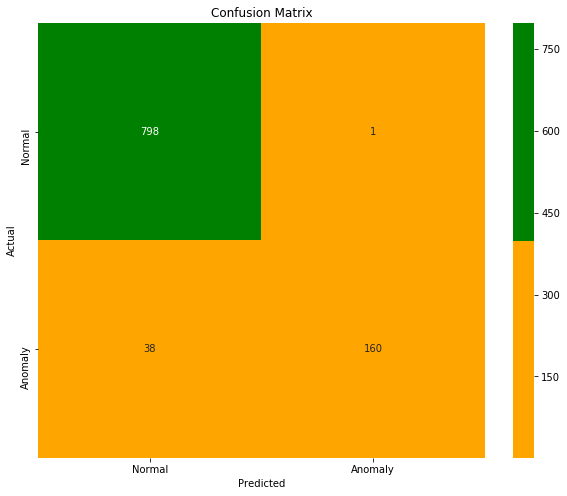

In [169]:
viz = Visualization()
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)
viz.draw_confusion_matrix(y_test2, y_pred2)
